In [4]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import librosa
from sklearn.model_selection import StratifiedGroupKFold
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
#from utils import process_data,read_data
import random
import re
from utils import extract_raw_data, DIR_PATH, PROCESSED_AUD_FILE_PATH, FEATURE_SETS, generate_train_val_test_idx, calculate_random_baseline_from_splits
import matplotlib.pyplot as plt
DIR_PATH = os.getcwd()


In [2]:
import opensmile

extractor = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    multiprocessing=True
)

In [4]:
audio_files = PROCESSED_AUD_FILE_PATH.glob("*.mp3")
audio_file_names = [i.stem for i in audio_files]
audio_file_names.sort()

In [39]:
# audio_file_names[0].split('-')
# pair_id - audio_file_names[0].split('-')[2]
# round - audio_file_names[0].split('-')[4]
# child - audio_file_names[0].split('-')[6]

child_link_csv = pd.read_csv('/media/chagan/2023-ELECTRA-field-MarcSchoolStudy/headset-audio/vidfile_link.csv')

In [64]:
list(child_link_csv['pair_id'].unique())

['N249',
 'N250',
 'N251',
 'N252',
 'N253',
 'N254',
 'N255',
 'N256',
 'N257',
 'N258',
 'N260',
 'N261',
 'N262',
 'N332',
 'N333',
 'N334',
 'N335',
 'P203',
 'P237',
 'P239',
 'P240',
 'P242',
 'P243',
 'P244',
 'P245',
 'P246',
 'P248',
 'P263',
 'P264',
 'P265',
 'P314',
 'P315',
 'P316',
 'P317',
 'P318']

In [53]:
#audio_file_names[0].split('-')
audio_file =  audio_file_names[1]
pair_id = audio_file.split('-')[2]
round = int(audio_file.split('-')[4])
child = int(audio_file.split('-')[6])
child_id = child_link_csv['child_id'].loc[ (child_link_csv['pair_id']==pair_id) & (child_link_csv['round']==round) & (child_link_csv['child']==child) ].reset_index(drop=True)[0] #get child_id from 'vidfile_link.csv'

In [54]:
audio_file, child_id

('headset-audio-N249-planning-1-child-2-processed', 34)

In [64]:
x, sr = librosa.load(
    Path.joinpath(PROCESSED_AUD_FILE_PATH, audio_file + ".mp3")
)
aud_df = pd.DataFrame(extractor.process_signal(x, sr))
features = [ 'Loudness_sma3',
 'alphaRatio_sma3',
 'hammarbergIndex_sma3',]


In [65]:
feature_outputs = aud_df[(col for col in features)].astype(float).reset_index(drop=True)

In [66]:
feature_outputs['pair_id']= pair_id
feature_outputs['round']= round
feature_outputs['child_id']= child_id
feature_outputs["condition"] = "positive" if (pair_id[0] == "P") else "negative"


In [88]:
feature_outputs.head(5)

,Loudness_sma3,alphaRatio_sma3,hammarbergIndex_sma3,pair_id,round,child_id,condition
0,0.001034,0.0,0.0,N249,1,32,negative
1,0.001034,0.0,0.0,N249,1,32,negative
2,0.001034,0.0,0.0,N249,1,32,negative
3,0.001034,0.0,0.0,N249,1,32,negative
4,0.001034,0.0,0.0,N249,1,32,negative


In [84]:
feature_outputs[ [~ ['pair_id','round', 'child_id', 'condition']] ]

TypeError: bad operand type for unary ~: 'list'

In [87]:
[ x for x in ( set(feature_outputs.columns) - set(['pair_id','round', 'child_id', 'condition'] ) )  ]

['hammarbergIndex_sma3', 'alphaRatio_sma3', 'Loudness_sma3']

In [ ]:
from ipydatagrid import DataGrid
DataGrid(feature_outputs.head(2000))

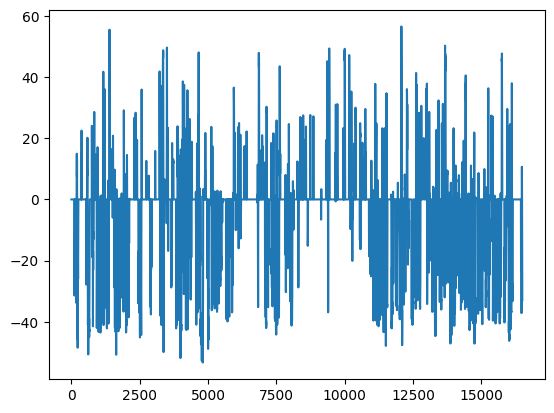

In [69]:
from matplotlib import pyplot as plt

plt.plot(feature_outputs['alphaRatio_sma3'])

In [56]:
import os
from pathlib import Path
import pandas as pd


from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

from utils import FEATURE_SETS, extract_raw_data



In [67]:
featureset_names = ['GeM', 'eGe', 'emob'] #, 'eGe', 'emob'
summary_stat = None #'mean'
for featureset_name in featureset_names:

    print(f'\nFeatureset name: {featureset_name}, Summary stat: {summary_stat}')
    extractor = FEATURE_SETS[featureset_name]['extractor']
    features = FEATURE_SETS[featureset_name]['features'](extractor)

    aud_df = extract_raw_data(extractor, featureset_name, features, summary_stat)

    X = aud_df[[ x for x in ( set(aud_df.columns) - set(['pair_id','round', 'child_id', 'condition'] ) )  ]]
    y = aud_df['condition'].apply(lambda x: 0.0 if x == 'negative' else 1.0)

    est = sm.OLS(y, X)
    est2 = est.fit()
    p_scores = est2.summary()
    print(est2.pvalues.sort_values())


Featureset name: GeM, Summary stat: None
Data already exists in disk, reading..

slope500-1500_sma3              0.000000e+00
HNRdBACF_sma3nz                 0.000000e+00
F0semitoneFrom27.5Hz_sma3nz     0.000000e+00
alphaRatio_sma3                 0.000000e+00
F1amplitudeLogRelF0_sma3nz     4.082879e-248
slope0-500_sma3                1.643727e-235
F2frequency_sma3nz              9.886462e-75
shimmerLocaldB_sma3nz           5.564949e-58
F3frequency_sma3nz              3.025090e-43
F2amplitudeLogRelF0_sma3nz      3.356739e-38
hammarbergIndex_sma3            3.381880e-27
F3amplitudeLogRelF0_sma3nz      8.284475e-19
jitterLocal_sma3nz              8.633351e-16
Loudness_sma3                   1.250840e-15
logRelF0-H1-H2_sma3nz           6.142177e-07
logRelF0-H1-A3_sma3nz           2.346544e-06
F1frequency_sma3nz              2.450744e-04
F1bandwidth_sma3nz              3.228296e-01
dtype: float64

Featureset name: eGe, Summary stat: None
Data already exists in disk, reading..

mfcc1_sma3 

In [68]:
est2.pvalues.sort_values()

pcm_loudness_sma      0.000000e+00
pcm_intensity_sma     0.000000e+00
F0env_sma             0.000000e+00
mfcc_sma[12]          0.000000e+00
mfcc_sma[10]         2.651072e-273
lspFreq_sma[7]       3.428604e-256
mfcc_sma[11]         6.352557e-245
mfcc_sma[4]          4.338014e-243
F0_sma               8.087481e-201
lspFreq_sma[0]       5.401814e-150
mfcc_sma[5]          3.896651e-146
lspFreq_sma[1]       3.190747e-144
lspFreq_sma[6]       3.087961e-136
mfcc_sma[7]          1.834847e-111
mfcc_sma[6]           3.444826e-97
mfcc_sma[2]           8.688319e-96
mfcc_sma[9]           1.139085e-80
mfcc_sma[8]           4.122054e-61
lspFreq_sma[3]        2.044604e-44
mfcc_sma[1]           1.376990e-41
voiceProb_sma         6.220165e-37
lspFreq_sma[2]        6.345225e-32
lspFreq_sma[4]        1.886000e-22
lspFreq_sma[5]        7.330803e-06
mfcc_sma[3]           1.489099e-01
pcm_zcr_sma           9.542078e-01
dtype: float64

In [69]:
featureset_names = ['GeM', 'eGe', 'emob'] #, 'eGe', 'emob'
summary_stat = 'mean'
for featureset_name in featureset_names:

    print(f'Featureset name: {featureset_name}, Summary stat: {summary_stat}')
    extractor = FEATURE_SETS[featureset_name]['extractor']
    features = FEATURE_SETS[featureset_name]['features'](extractor)

    aud_df = extract_raw_data(extractor, featureset_name, features, summary_stat)

    X = aud_df[[ x for x in ( set(aud_df.columns) - set(['pair_id','round', 'child_id', 'condition'] ) )  ]]
    y = aud_df['condition'].apply(lambda x: 0.0 if x == 'negative' else 1.0)

    est = sm.OLS(y, X)
    est2 = est.fit()
    p_scores = est2.summary()
    print(est2.pvalues.sort_values())

Featureset name: GeM, Summary stat: mean
Data already exists in disk, reading..

F0semitoneFrom27.5Hz_sma3nz    4.869380e-24
logRelF0-H1-A3_sma3nz          4.234024e-18
shimmerLocaldB_sma3nz          1.783791e-11
F3amplitudeLogRelF0_sma3nz     5.846338e-11
F2amplitudeLogRelF0_sma3nz     9.487205e-09
F1bandwidth_sma3nz             4.314803e-08
logRelF0-H1-H2_sma3nz          4.546764e-08
F1amplitudeLogRelF0_sma3nz     6.977992e-06
Loudness_sma3                  1.034264e-02
HNRdBACF_sma3nz                2.710080e-02
alphaRatio_sma3                4.277568e-02
slope500-1500_sma3             1.567394e-01
slope0-500_sma3                2.689470e-01
hammarbergIndex_sma3           3.893769e-01
jitterLocal_sma3nz             5.798820e-01
F3frequency_sma3nz             6.961166e-01
F2frequency_sma3nz             7.396738e-01
F1frequency_sma3nz             7.445593e-01
dtype: float64
Featureset name: eGe, Summary stat: mean
Data already exists in disk, reading..

F0semitoneFrom27.5Hz_sma3nz    

In [3]:
extractor = FEATURE_SETS['emob']['extractor']
features = features = [    'mfcc_sma[1]',
                'mfcc_sma[2]',
                'mfcc_sma[3]',
                'mfcc_sma[4]',
                'mfcc_sma[5]',
                'mfcc_sma[6]',
                'mfcc_sma[7]',
                'mfcc_sma[8]',
                'mfcc_sma[9]',
                'mfcc_sma[10]',
                'mfcc_sma[11]',
                'mfcc_sma[12]'
            ]#FEATURE_SETS['emob']['features'](extractor)

aud_mean_data = extract_raw_data(extractor, 'emob', features, summary_stat = 'mean')
pair_id_list = list(set(aud_mean_data["pair_id"]))

Data already exists in disk, reading..



In [4]:
#Test
lst = ['P265', 'N260', 'N251', 'P245', 'P318', 'P240', 'P203', 'N334', 'P264', 'N254', 'N249']

idx_p = len([p for p in aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)] if p[0] == 'P'])
idx_n = len([n for n in aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)] if n[0] == 'N'])

print(idx_p/aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)].shape[0], idx_n/aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)].shape[0])

0.5625 0.4375


In [5]:
#Train
lst = ['P263', 'P314', 'N253', 'N262', 'N252', 'P237', 'P248', 'P316', 'N333', 'P246', 'P315', 'N250', 'P239', 'N256', 'P242', 'P243', 'N257', 'N258', 'N332', 'N255', 'N335', 'N261', 'P244', 'P317']

idx_p = len([p for p in aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)] if p[0] == 'P'])
idx_n = len([n for n in aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)] if n[0] == 'N'])

print(idx_p/aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)].shape[0], idx_n/aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(lst)].shape[0])

0.5070422535211268 0.49295774647887325


In [6]:
extractor = FEATURE_SETS['emob']['extractor']
features = FEATURE_SETS['emob']['features'](extractor)
aud_mean_data = extract_raw_data(extractor, 'emob', features, summary_stat = 'mean')
pair_id_list = list(set(aud_mean_data["pair_id"]))

Data already exists in disk, reading..



In [153]:
a = [1,2,3]
b= a

In [154]:
b.remove(a[0])


In [157]:
a

[2, 3]

In [148]:
b = a.copy()
b.remove(a[1])

In [149]:
b

[1, 3]

In [134]:
# X = aud_mean_data.loc[aud_mean_data["pair_id"].isin(['N250'])]['condition']
aud_mean_data.loc[aud_mean_data["pair_id"].isin(['N250'])].reset_index(drop='True')

,pair_id,round,child_id,condition,pcm_intensity_sma,pcm_loudness_sma,mfcc_sma[1],mfcc_sma[2],mfcc_sma[3],mfcc_sma[4],...,lspFreq_sma[2],lspFreq_sma[3],lspFreq_sma[4],lspFreq_sma[5],lspFreq_sma[6],lspFreq_sma[7],pcm_zcr_sma,voiceProb_sma,F0_sma,F0env_sma
0,N250,1,37,negative,3.927087e-08,0.106000,-15.521990,8.256252,8.689068,-2.047385,...,0.943936,1.304752,1.620104,1.934440,2.289817,2.721537,0.336906,0.482684,76.873466,265.352264
1,N250,1,3,negative,8.205964e-09,0.039935,-9.473443,5.150198,-2.648713,-2.434262,...,1.046139,1.383572,1.727206,2.051286,2.405632,2.779128,0.728674,0.242275,48.255054,258.501770
2,N250,2,37,negative,4.391135e-08,0.143440,-9.485168,6.111446,2.391533,-6.466064,...,0.923050,1.268556,1.589528,1.903102,2.265313,2.706193,0.305076,0.478598,82.716225,231.517380
3,N250,2,3,negative,2.784043e-08,0.080068,-0.836999,-8.515507,-3.188289,-6.025130,...,0.918117,1.281155,1.678821,2.038169,2.412632,2.778270,0.609925,0.298393,53.979919,228.159973
4,N250,3,37,negative,7.385312e-09,0.049773,-11.554399,-1.261121,4.685319,-4.342163,...,1.027438,1.372701,1.668351,1.971233,2.313543,2.701235,0.621512,0.282458,60.309750,308.901245
5,N250,3,3,negative,3.778519e-08,0.072772,-1.716223,-4.739263,-0.580982,-0.201133,...,0.932666,1.291494,1.684165,2.038761,2.408161,2.776986,0.626976,0.271157,48.049492,277.206482


In [130]:
X.index

Index([6, 7, 8, 9, 10, 11], dtype='int64')

In [119]:
for i in range(3,9):
    train_idx, val_idx, test_idx, train_pair_ids, val_pair_ids, test_pair_ids = generate_train_val_test_idx(aud_mean_data, 24, i)

    train_rb, val_rb, test_rb = calculate_random_baseline_from_splits(aud_mean_data, train_idx, val_idx, test_idx)

    print(train_rb, val_rb, test_rb )

    print(len(test_pair_ids), test_pair_ids)


0.3966705556995938 0.42182367149758454 0.5
7 ['P240', 'N255', 'N260', 'N256', 'P242', 'P263', 'P203']
0.41065563544436784 0.4316993464052287 0.5
7 ['P243', 'N334', 'P317', 'N250', 'P237', 'N262', 'N256']
0.39990393302032035 0.451547619047619 0.5
7 ['P243', 'N334', 'P317', 'N250', 'P237', 'N262', 'N256']
0.4133710672443067 0.3971028971028971 0.5
7 ['P243', 'N334', 'P317', 'N250', 'P237', 'N262', 'N256']
0.39925672290939057 0.4966269841269841 0.5
7 ['P243', 'N334', 'P317', 'N250', 'P237', 'N262', 'N256']
0.4131818872120209 0.36666666666666664 0.5
7 ['P243', 'N334', 'P317', 'N250', 'P237', 'N262', 'N256']


In [122]:
for i in val_idx:
    print(i)

[18, 19, 20, 21, 100, 101, 102, 103, 104, 105]
[48, 49, 50, 51, 52, 53, 54, 55, 90, 91, 92, 93]
[6, 7, 8, 9, 10, 11, 124, 125, 126, 127, 128, 129]
[42, 43, 44, 45, 46, 47, 118, 119, 120, 121, 122, 123]
[0, 1, 2, 3, 4, 5, 112, 113, 114, 115, 116, 117]
[56, 57, 58, 59, 60, 61, 94, 95, 96, 97, 98, 99]
[22, 23, 24, 25, 26, 27, 78, 79, 80, 81, 82, 83]
[12, 13, 14, 15, 16, 17, 84, 85, 86, 87, 88, 89]
[36, 37, 38, 39, 40, 41, 138, 139, 140, 141, 142, 143]
[28, 29, 30, 31, 32, 33, 34, 35, 106, 107, 108, 109, 110, 111]
[62, 63, 64, 65, 66, 67, 130, 131, 132, 133, 134, 135, 136, 137]
[68, 69, 70, 71, 150, 151, 152, 153]
[72, 73, 74, 75, 76, 77, 154, 155, 156, 157, 158, 159]


In [3]:
aud_mean_data.pair_id.unique()

array(['N249', 'N250', 'N251', 'N252', 'N253', 'N254', 'N255', 'N256',
       'N257', 'N258', 'N260', 'N261', 'N262', 'N332', 'N333', 'N334',
       'N335', 'P203', 'P237', 'P239', 'P240', 'P242', 'P243', 'P244',
       'P245', 'P246', 'P248', 'P263', 'P264', 'P265', 'P314', 'P315',
       'P316', 'P317', 'P318'], dtype=object)

In [4]:
len(aud_mean_data.pair_id.unique())

35

In [57]:
aud_mean_data.head(5)

,pair_id,round,child_id,condition,pcm_intensity_sma,pcm_loudness_sma,mfcc_sma[1],mfcc_sma[2],mfcc_sma[3],mfcc_sma[4],...,lspFreq_sma[2],lspFreq_sma[3],lspFreq_sma[4],lspFreq_sma[5],lspFreq_sma[6],lspFreq_sma[7],pcm_zcr_sma,voiceProb_sma,F0_sma,F0env_sma
0,N249,1,32,negative,9.375388e-09,0.040193,-1.661662,-0.093014,-4.090717,-5.949376,...,0.985701,1.331274,1.706071,2.057619,2.428690,2.779023,0.689507,0.277408,61.017811,262.657166
1,N249,1,34,negative,2.276808e-08,0.051616,-6.176218,-1.247608,4.871886,-1.846551,...,1.023809,1.344877,1.677853,2.017229,2.396503,2.758842,0.739456,0.184363,31.176229,269.896423
2,N249,2,32,negative,3.115567e-08,0.046203,-3.659975,-2.337993,-3.478288,-6.396125,...,0.977513,1.311667,1.688759,2.051585,2.426927,2.773250,0.628637,0.324092,71.597031,262.304321
3,N249,2,34,negative,6.238546e-08,0.072910,-5.677544,-2.334379,5.103523,-1.643911,...,1.008695,1.334066,1.665522,2.010166,2.390657,2.756300,0.686658,0.224573,38.323509,246.593918
4,N249,3,32,negative,9.962439e-08,0.101890,-13.316648,4.079259,-1.217608,1.691975,...,1.083097,1.429548,1.817988,2.112318,2.456782,2.713640,0.548613,0.345794,60.253269,275.105865


In [48]:
len(pair_id_list)

35

In [8]:
outliers = ['N255', 'P245', 'P318']

pair_id_list_new = [pair_id for pair_id in pair_id_list if pair_id not in outliers]

In [9]:
print( [x for x in pair_id_list_new if x[0]=='P' and x[1]=='2'] )
print( [x for x in pair_id_list_new if x[0]=='N' and x[1]=='2'] )
print( [x for x in pair_id_list_new if x[0]=='P' and x[1]=='3'] )
print( [x for x in pair_id_list_new if x[0]=='N' and x[1]=='3'] )

['P239', 'P203', 'P237', 'P246', 'P243', 'P248', 'P242', 'P244', 'P263', 'P265', 'P264', 'P240']
['N249', 'N250', 'N252', 'N251', 'N261', 'N253', 'N258', 'N256', 'N260', 'N262', 'N254', 'N257']
['P317', 'P314', 'P316', 'P315']
['N332', 'N333', 'N335', 'N334']


In [105]:
import more_itertools


def generate_train_val_idx(df, seed, sklearn = False, k=8,  level=1, outliers= None):
    train_idx, val_idx, train_pair_ids, val_pair_ids = list(), list(), list(), list()
    
    random.seed(seed)

    if outliers is None:
        pair_id_list = list(set(df["pair_id"]))
        pair_id_list.sort()
        random.shuffle(pair_id_list)
    else:
        pair_id_list = [pair_id for pair_id in list(set(df["pair_id"])) if pair_id not in outliers]
        pair_id_list.sort()
        random.shuffle(pair_id_list)
    if not sklearn:
        p_y2 = [x for x in pair_id_list if x[0]=='P' and x[1]=='2']
        n_y2 = [x for x in pair_id_list if x[0]=='N' and x[1]=='2']
        p_y3 = [x for x in pair_id_list if x[0]=='P' and x[1]=='3']
        n_y3 = [x for x in pair_id_list if x[0]=='N' and x[1]=='3']
        
        if level == 1:
            p = p_y2 + p_y3
            n = n_y2 + n_y3
            print(len(p),len(n))
            for i, j in zip (more_itertools.batched(p, int(len(p)/k)), more_itertools.batched(n, int(len(n)/k))):
                val_pair_id = list(i+j)
                val_pair_ids.append(val_pair_id)
                val_idx.append(df.loc[ df["pair_id"].isin(val_pair_id)].index.to_list())

                train_pair_id = [x for x in pair_id_list if x not in val_pair_id]
                train_pair_ids.append(train_pair_id)
                train_idx.append(df.loc[ df["pair_id"].isin(train_pair_id)].index.to_list())
            
            return train_idx, val_idx, train_pair_ids, val_pair_ids
        else:

            for i, j, k, l in zip (more_itertools.batched(p_y2, int(len(p_y2)/k)), more_itertools.batched(p_y3, int(len(p_y3)/k)), more_itertools.batched(n_y2, int(len(n_y2)/k)), more_itertools.batched(n_y3, int(len(n_y3)/k))):
                val_pair_id = list(i+j+k+l)
                val_pair_ids.append(val_pair_id)
                val_idx.append(df.loc[ df["pair_id"].isin(val_pair_id)].index.to_list())

                train_pair_id = [x for x in pair_id_list if x not in val_pair_id]
                train_pair_ids.append(train_pair_id)
                train_idx.append(df.loc[ df["pair_id"].isin(train_pair_id)].index.to_list())

            return train_idx, val_idx, train_pair_ids, val_pair_ids        
    else:

        X = df[[x for x in df.columns if x not in ['pair_id','round','child_id','condition']]]
        y = df['condition']
        groups = df.pair_id

        cv = StratifiedGroupKFold(n_splits=8, shuffle=True)

        for train, val in cv.split(X, y, groups):
            train_idx.append(train)
            train_pair_ids.append( list(set(aud_mean_data['pair_id'].loc[train])) )
            
            val_idx.append(val)
            val_pair_ids.append( list(set(aud_mean_data['pair_id'].loc[val])) )
        
        return train_idx, val_idx, train_pair_ids, val_pair_ids

In [106]:
#tr, te = generate_train_test_idx(aud_mean_data, k=4, level=2)
train_idx, val_idx, train_pair_ids, val_pair_ids = generate_train_val_idx(aud_mean_data, seed=24, sklearn=True, k=8, level=1)

In [111]:
def generate_clean_train_idx(df, test, v_pids):
    t_pid = []
    t_idx = []
    pid_list = df.pair_id.unique()
    for i in v_pids:
        clean = [x for x in pid_list if x not in (test + i)]
        t_pid.append(clean)

        t_idx.append( df.loc[ df["pair_id"].isin(clean)].index.to_list() )
    
    return t_pid, t_idx

In [115]:
train_pair_ids, train_idx =  generate_clean_train_idx(aud_mean_data, test=val_pair_ids[0], v_pids=val_pair_ids[1:])

In [116]:
for i in val_pair_ids:
    print(i,end='\n')

['P317', 'P264', 'N261', 'N258']
['P244', 'P265', 'N332', 'N262', 'N249']
['P243', 'P203', 'P318', 'P314']
['N334', 'P246', 'P237', 'P248', 'N333']
['N335', 'N250', 'P315', 'N254']
['N251', 'P316', 'N255', 'P239']
['N257', 'P263', 'N256', 'N252', 'P240']
['N253', 'N260', 'P242', 'P245']


In [117]:
for i in train_pair_ids:
    print(i,end='\n')

['N250', 'N251', 'N252', 'N253', 'N254', 'N255', 'N256', 'N257', 'N260', 'N333', 'N334', 'N335', 'P203', 'P237', 'P239', 'P240', 'P242', 'P243', 'P245', 'P246', 'P248', 'P263', 'P314', 'P315', 'P316', 'P318']
['N249', 'N250', 'N251', 'N252', 'N253', 'N254', 'N255', 'N256', 'N257', 'N260', 'N262', 'N332', 'N333', 'N334', 'N335', 'P237', 'P239', 'P240', 'P242', 'P244', 'P245', 'P246', 'P248', 'P263', 'P265', 'P315', 'P316']
['N249', 'N250', 'N251', 'N252', 'N253', 'N254', 'N255', 'N256', 'N257', 'N260', 'N262', 'N332', 'N335', 'P203', 'P239', 'P240', 'P242', 'P243', 'P244', 'P245', 'P263', 'P265', 'P314', 'P315', 'P316', 'P318']
['N249', 'N251', 'N252', 'N253', 'N255', 'N256', 'N257', 'N260', 'N262', 'N332', 'N333', 'N334', 'P203', 'P237', 'P239', 'P240', 'P242', 'P243', 'P244', 'P245', 'P246', 'P248', 'P263', 'P265', 'P314', 'P316', 'P318']
['N249', 'N250', 'N252', 'N253', 'N254', 'N256', 'N257', 'N260', 'N262', 'N332', 'N333', 'N334', 'N335', 'P203', 'P237', 'P240', 'P242', 'P243', 'P2

In [104]:
len(list(set(aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(train_pids)])))

31

In [96]:
X = aud_mean_data[[x for x in aud_mean_data.columns if x not in ['pair_id','round','child_id','condition']]]
y = aud_mean_data['condition']

groups = aud_mean_data.pair_id
print("ORIGINAL POSITIVE RATIO:")
cv = StratifiedGroupKFold(n_splits=8, shuffle=True)
tr = []
te = []
for fold, (train_idxs, test_idxs) in enumerate(cv.split(X, y, groups)):
    print("Fold :", fold)
    train_pids = set(groups[train_idxs])
    test_pids = set(groups[test_idxs])

    print("TRAIN GROUPS        :", train_pids)
    print('Train pos percentage:', len([p for p in aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(train_pids)] if p[0] == 'P']) / aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(train_pids)].shape[0])
    print("TEST GROUPS         :", test_pids)
    print('Test pos percentage:', len([p for p in aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(test_pids)] if p[0] == 'P']) / aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(test_pids)].shape[0])

    overlapping_idxs = [value for value in test_pids if value in train_pids]

    print(f'Overlapping idxs: {overlapping_idxs}')  


ORIGINAL POSITIVE RATIO:
Fold : 0
TRAIN GROUPS        : {'N250', 'P264', 'P237', 'P248', 'P203', 'P318', 'P314', 'N258', 'N253', 'P245', 'N254', 'N260', 'N334', 'N256', 'P240', 'P243', 'N332', 'P246', 'N255', 'N251', 'N257', 'P315', 'P239', 'N333', 'N335', 'P244', 'P263', 'P265', 'N261', 'N249', 'P317'}
Train pos percentage: 0.5274725274725275
TEST GROUPS         : {'N262', 'P316', 'P242', 'N252'}
Test pos percentage: 0.5
Overlapping idxs: []
Fold : 1
TRAIN GROUPS        : {'N250', 'P316', 'N252', 'P264', 'P237', 'N262', 'P248', 'P203', 'P314', 'N258', 'P245', 'N254', 'N260', 'N334', 'N256', 'P240', 'N332', 'P246', 'N255', 'N251', 'N257', 'P242', 'P315', 'P239', 'N333', 'P244', 'P263', 'P265', 'N261', 'N249', 'P317'}
Train pos percentage: 0.5164835164835165
TEST GROUPS         : {'N253', 'N335', 'P318', 'P243'}
Test pos percentage: 0.5833333333333334
Overlapping idxs: []
Fold : 2
TRAIN GROUPS        : {'P316', 'N252', 'P264', 'P237', 'N262', 'P248', 'P203', 'P318', 'N258', 'N253', 'P24

0.8446601941747572
0.8932038834951457
0.8932038834951457
0.8737864077669902
0.8446601941747572
0.9029126213592233
0.8640776699029126
0.883495145631068


In [76]:
aud_mean_data['pair_id'].loc[aud_mean_data['pair_id'].isin(train_pids)]

6      N250
7      N250
8      N250
9      N250
10     N250
       ... 
201    P318
202    P318
203    P318
204    P318
205    P318
Name: pair_id, Length: 132, dtype: object

[['P244', 'P237', 'P265', 'N256', 'N252', 'N249'],
 ['P240', 'P239', 'P246', 'N258', 'N253', 'N251'],
 ['P243', 'P264', 'P242', 'N254', 'N255', 'N260'],
 ['P245', 'P314', 'P316', 'N261', 'N335', 'N334'],
 ['P315', 'P317', 'P318', 'N333', 'N332']]

In [42]:
for i in range(0,len(val_pair_ids)):
    test_pair_ids = val_pair_ids[i]
    val_pair_ids_fold = val_pair_ids.copy()
    val_pair_ids_fold.remove(test_pair_ids)

    print('Test: ', test_pair_ids, ('\n'))
    print('Val: ')
    for j in val_pair_ids_fold:
        print(j, end='\n')
    print('\n')

Test:  ['P203', 'P248', 'P263', 'N257', 'N250', 'N262'] 

Val: 
['P244', 'P237', 'P265', 'N256', 'N252', 'N249']
['P240', 'P239', 'P246', 'N258', 'N253', 'N251']
['P243', 'P264', 'P242', 'N254', 'N255', 'N260']
['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


Test:  ['P244', 'P237', 'P265', 'N256', 'N252', 'N249'] 

Val: 
['P203', 'P248', 'P263', 'N257', 'N250', 'N262']
['P240', 'P239', 'P246', 'N258', 'N253', 'N251']
['P243', 'P264', 'P242', 'N254', 'N255', 'N260']
['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


Test:  ['P240', 'P239', 'P246', 'N258', 'N253', 'N251'] 

Val: 
['P203', 'P248', 'P263', 'N257', 'N250', 'N262']
['P244', 'P237', 'P265', 'N256', 'N252', 'N249']
['P243', 'P264', 'P242', 'N254', 'N255', 'N260']
['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


Test:  ['P243', 'P264', 'P242', 'N254', 'N255', 'N260'] 

Val: 
['P203', 'P248', 'P263', 'N

In [32]:
for i in range(0,len(val_pair_ids)):
    val = val_pair_ids[]
    for j in val_pair_ids[4:]:
        print(j, end='\n')
    print('\n')

['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']


['P245', 'P314', 'P316', 'N261', 'N335', 'N334']
['P315', 'P317', 'P318', 'N333', 'N332']




In [7]:
for x,y in zip(train_pair_ids,test_pair_ids):
    print(x, y)

['N335', 'N334', 'P314', 'P316', 'P244', 'P315', 'P237', 'P317', 'N256', 'P265', 'P240', 'N252', 'P239', 'N333', 'N249', 'N258', 'P246', 'N253', 'P318', 'P243', 'N251', 'P264', 'P242', 'N254', 'N255', 'N260', 'N332', 'N261', 'P245'] ['P203', 'P248', 'P263', 'N257', 'N250', 'N262']
['P203', 'N335', 'N334', 'P248', 'N257', 'P263', 'P314', 'P316', 'N250', 'N262', 'P315', 'P317', 'P240', 'P239', 'N333', 'N258', 'P246', 'N253', 'P318', 'P243', 'N251', 'P264', 'P242', 'N254', 'N255', 'N260', 'N332', 'N261', 'P245'] ['P244', 'P237', 'P265', 'N256', 'N252', 'N249']
['P203', 'N335', 'N334', 'P248', 'N257', 'P263', 'P314', 'P316', 'N250', 'N262', 'P244', 'P315', 'P237', 'P317', 'N256', 'P265', 'N252', 'N333', 'N249', 'P318', 'P243', 'P264', 'P242', 'N254', 'N255', 'N260', 'N332', 'N261', 'P245'] ['P240', 'P239', 'P246', 'N258', 'N253', 'N251']
['P203', 'N335', 'N334', 'P248', 'N257', 'P263', 'P314', 'P316', 'N250', 'N262', 'P244', 'P315', 'P237', 'P317', 'N256', 'P265', 'P240', 'N252', 'P239', '

In [26]:
df = aud_mean_data.copy()

In [32]:
split_stats={}

pair_id_list = list(set(df["pair_id"]))  # get unique pair_ids
flag=True
split_ratio = 0.8
df_size = df.shape[0]

while flag:

    random.shuffle(pair_id_list)
    split_index = round(split_ratio * len(pair_id_list))

    df_sliced_with_train_pid = df.loc[df["pair_id"].isin(pair_id_list[: split_index])].reset_index(drop=True)
    train_length = df_sliced_with_train_pid.shape[0]

    condition_1 = train_length/df_size > (split_ratio-0.05)
    condition_2 = train_length/df_size < (split_ratio+0.05)

    condition_3 = len([d for d in pair_id_list[split_index :] if d[0]=='N']) - len([d for d in pair_id_list[split_index :] if d[0]=='P']) < 1

    if condition_1 and  condition_2 and condition_3:
        flag=False




In [33]:
split_stats['Split ratio']=train_length/df_size
split_stats['IDs in Train']=pair_id_list[: split_index]
split_stats['IDs in Test']=pair_id_list[split_index : ]
split_stats['Number of Ns in train']=len([d for d in pair_id_list[: split_index] if d[0]=='N'])
split_stats['Number of Ps in train']=len([d for d in pair_id_list[: split_index] if d[0]=='P'])
split_stats['Number of Ns in test']=len([d for d in pair_id_list[split_index :] if d[0]=='N'])
split_stats['Number of Ps in test']=len([d for d in pair_id_list[split_index :] if d[0]=='P'])

In [34]:
split_stats

{'Split ratio': 0.7961165048543689,
 'IDs in Train': ['N261',
  'N335',
  'P243',
  'P237',
  'N257',
  'P245',
  'N250',
  'N249',
  'N254',
  'P318',
  'N253',
  'P264',
  'P314',
  'N334',
  'P316',
  'P265',
  'P315',
  'N332',
  'N256',
  'P239',
  'N255',
  'P244',
  'P263',
  'N258',
  'N262',
  'P246',
  'P240',
  'N252'],
 'IDs in Test': ['N333', 'P242', 'P203', 'P248', 'N260', 'P317', 'N251'],
 'Number of Ns in train': 14,
 'Number of Ps in train': 14,
 'Number of Ns in test': 3,
 'Number of Ps in test': 4}

In [66]:
tot_tr = 0
tot_te = 0
for x,y in zip(tr,te):
    #print(aud_mean_data['pair_id'].loc[x].unique()) 
    #print(aud_mean_data['pair_id'].loc[y].unique())
    tr_p = len([p for p in aud_mean_data['pair_id'].loc[x] if p[0] == 'P'])
    tr_n = len([n for n in aud_mean_data['pair_id'].loc[x] if n[0] == 'N'])
    te_p = len([p for p in aud_mean_data['pair_id'].loc[y] if p[0] == 'P'])
    te_n = len([n for n in aud_mean_data['pair_id'].loc[y] if n[0] == 'N'])
    print(f'Train P: {tr_p} ; N: {tr_n} ; Random baseline: {tr_p/(tr_p+tr_n)}')
    print(f'Test P: {te_p} ; N: {te_n} ; Random baseline: {te_p/(te_p+te_n)}', '\n')

    tot_tr += tr_p/(tr_p+tr_n)
    tot_te += te_p/(te_p+te_n)
print(tot_tr/len(tr))
print(tot_te/len(te))

Train P: 88 ; N: 80 ; Random baseline: 0.5238095238095238
Test P: 20 ; N: 18 ; Random baseline: 0.5263157894736842 

Train P: 92 ; N: 80 ; Random baseline: 0.5348837209302325
Test P: 16 ; N: 18 ; Random baseline: 0.47058823529411764 

Train P: 90 ; N: 80 ; Random baseline: 0.5294117647058824
Test P: 18 ; N: 18 ; Random baseline: 0.5 

Train P: 88 ; N: 80 ; Random baseline: 0.5238095238095238
Test P: 20 ; N: 18 ; Random baseline: 0.5263157894736842 

Train P: 90 ; N: 82 ; Random baseline: 0.5232558139534884
Test P: 18 ; N: 16 ; Random baseline: 0.5294117647058824 

Train P: 92 ; N: 88 ; Random baseline: 0.5111111111111111
Test P: 16 ; N: 10 ; Random baseline: 0.6153846153846154 

0.5243802430532937
0.5280026990553306


In [195]:
for x,y in zip(tr, te):
    overlapping_idxs = [value for value in x if value in y]

    print(f'Overlapping idxs: {overlapping_idxs}')    

Overlapping idxs: []
Overlapping idxs: []
Overlapping idxs: []
Overlapping idxs: []
Overlapping idxs: []
Overlapping idxs: []
Overlapping idxs: []
Overlapping idxs: []
Overlapping idxs: []


In [164]:
aud_mean_data_1 = extract_raw_data(extractor, 'emob', features)

Data already exists in disk, reading..



In [165]:
aud_mean_data_1.shape

(2707582, 30)

In [176]:
tr, te = generate_train_test_idx(aud_mean_data_1, k=5, level=1, outliers=outliers)

In [177]:
for x,y in zip(tr,te):
    print(len(x), len(y), len(y)/(len(x) + len(y)))

2099298 408818 0.16299804315270905
2137254 370862 0.14786477180481286
2060214 447902 0.17858105446478553
1976258 531858 0.21205478534485644
2026830 481286 0.19189144361744034
2240726 267390 0.10660990161539578


In [104]:
from sklearn.model_selection import StratifiedKFold

x_col = [x for x in aud_mean_data.columns if x != 'condition']
X = aud_mean_data[x_col]
Y = aud_mean_data['condition']

skf = StratifiedKFold(n_splits=8)

skf.get_n_splits(X, Y)

8

In [ ]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Train idxs={aud_mean_data.loc[train_index].pair_id.unique()}")

    print(f"  Test:  index={test_index}")
    print(f"  Test idxs={aud_mean_data.loc[test_index].pair_id.unique()}")

    overlapping_idxs = [value for value in aud_mean_data.loc[train_index].pair_id.unique() if value in aud_mean_data.loc[test_index].pair_id.unique()]

    print(f'Overlapping idxs: {overlapping_idxs}')

In [83]:
df_result = pd.read_csv('/media/chagan/2023-ELECTRA-field-MarcSchoolStudy/bc_video/inference/sklearn/experiment-2/results_df_test.csv')

In [84]:
df_result.sort_values(by=['Best test score'], ascending=False).to_csv('/media/chagan/2023-ELECTRA-field-MarcSchoolStudy/bc_video/inference/sklearn/experiment-2/results_sorted.csv', index=False)

In [211]:
df_result.sort_values(by=['Features'], ascending=False).head(20)['Best params']

302    ['logRelF0-H1-A3_sma3nz', 'shimmerLocaldB_sma3...
2      ['mfcc_sma[1]', 'mfcc_sma[2]', 'mfcc_sma[3]', ...
138    ['F0semitoneFrom27.5Hz_sma3nz', 'logRelF0-H1-A...
150    ['F0semitoneFrom27.5Hz_sma3nz', 'logRelF0-H1-A...
34     ['F0semitoneFrom27.5Hz_sma3nz', 'logRelF0-H1-A...
106    ['mfcc_sma[1]', 'mfcc_sma[2]', 'mfcc_sma[3]', ...
146    ['logRelF0-H1-A3_sma3nz', 'shimmerLocaldB_sma3...
86     ['F0semitoneFrom27.5Hz_sma3nz', 'logRelF0-H1-A...
54     ['mfcc_sma[1]', 'mfcc_sma[2]', 'mfcc_sma[3]', ...
262    ['mfcc_sma[1]', 'mfcc_sma[2]', 'mfcc_sma[3]', ...
182    ['lspFreq_sma[1]', 'lspFreq_sma[7]', 'lspFreq_...
114    ['pcm_zcr_sma', 'lspFreq_sma[1]', 'lspFreq_sma...
26     ['lspFreq_sma[1]', 'lspFreq_sma[7]', 'lspFreq_...
254    ['F0semitoneFrom27.5Hz_sma3nz', 'logRelF0-H1-A...
174                                 ['pcm_loudness_sma']
210    ['mfcc_sma[1]', 'mfcc_sma[2]', 'mfcc_sma[3]', ...
126                 ['lspFreq_sma[1]', 'lspFreq_sma[7]']
202    ['F0semitoneFrom27.5Hz_s

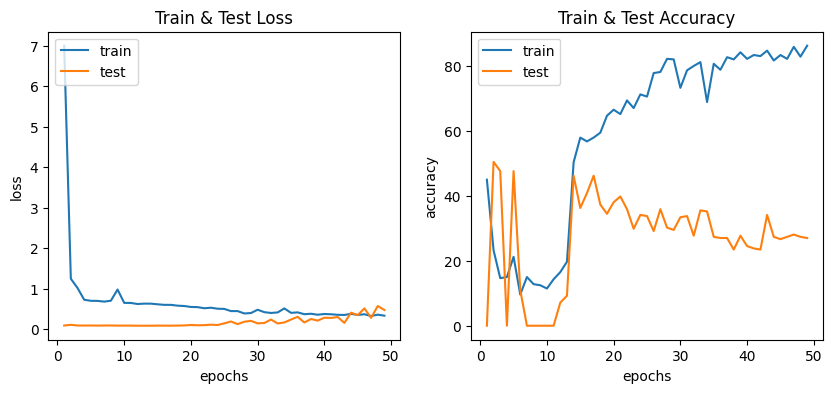

In [8]:
DIR_PATH = Path('/media/chagan/2023-ELECTRA-field-MarcSchoolStudy/e2ecv')
EXPERIMENT = 4
EPOCH_DATA_SAVEPATH = DIR_PATH / 'inference' / f'experiment-{EXPERIMENT}' / 'data'
epochs = 49

A = np.load(EPOCH_DATA_SAVEPATH / 'epoch_training_losses.npy')
B = np.load(EPOCH_DATA_SAVEPATH / 'epoch_training_scores.npy')
C = np.load(EPOCH_DATA_SAVEPATH / 'epoch_test_loss.npy')
D = np.load(EPOCH_DATA_SAVEPATH / 'epoch_test_score.npy')

# plot
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[1:])  # train loss (on epoch end) [:, -1]
plt.plot(np.arange(1, epochs + 1), C[1:])         #  test loss (on epoch end)
plt.title("Train & Test Loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B[1:])  # train accuracy (on epoch end)
plt.plot(np.arange(1, epochs + 1), D[1:])         #  test accuracy (on epoch end)
# plt.plot(histories.losses_val)
plt.title("Train & Test Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")